## Write an Algorithm for a Dog Identification App 

### Based on Convolutional Neural Networks

Let's stand the problem :
This project accepts any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

In practice we should piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed. However, it is just for learning purposes. Then, we will go ahead.

## Import Datasets

First of all, lets load our datasets

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).

lfw/Kate_Lee/Kate_Lee_0001.jpg


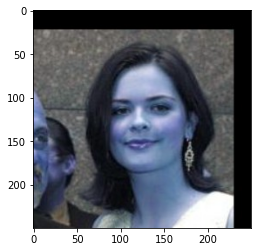

Number of faces detected: 1


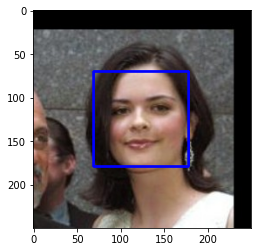

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
print(human_files[0])
img = cv2.imread(human_files[0])
plt.imshow(img)
plt.show()
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector

Once seen that. We will build a function that returns True if a human face is detected in an image and `False` otherwise.
Our function will take as input a file path and will return a boolean value.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Now, lets test our function with a part of our dataset. An see its performance agains human and dog images.

In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_faces_detected  = 0
false_human_faces_detected  = 0
for file in human_files_short:
    if face_detector(file):
        human_faces_detected += 1 
classified_human_faces = 100 * human_faces_detected/len(human_files_short)
print("% Correctly classified human faces: ", classified_human_faces)

for file in dog_files_short:
    if face_detector(file):
        false_human_faces_detected += 1 
classified_dog_faces_as_humans = 100 * false_human_faces_detected/len(dog_files_short)
print("% Wrong dog faces classied as human : ", classified_dog_faces_as_humans)

% Correctly classified human faces:  99.0
% Wrong dog faces classied as human :  7.0


This is the most clear and easy to use method. However, there exists more complex solutions like the proposed in:
https://github.com/timesler/facenet-pytorch/

In [7]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


human_faces_detected  = 0
false_human_faces_detected  = 0
for file in human_files_short:
    img = cv2.imread(file)
    dim = (160, 160)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    x_aligned = mtcnn(resized, return_prob=False)
    if x_aligned is not None:
        human_faces_detected += 1 
classified_human_faces = 100 * human_faces_detected/len(human_files_short)
print("% Correctly classified human faces: ", classified_human_faces)

for file in dog_files_short:
    img = cv2.imread(file)
    dim = (160, 160)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    x_aligned = mtcnn(resized, return_prob=False)
    if x_aligned is not None:
        false_human_faces_detected += 1 
classified_dog_faces_as_humans = 100 * false_human_faces_detected/len(dog_files_short)
print("% Wrong dog faces classied as human : ", classified_dog_faces_as_humans)


% Correctly classified human faces:  98.0
% Wrong dog faces classied as human :  6.0


It is a complex solution, although its parameters are more difficult to tune. Because of that, we will proceed with the first option, the cascade classifier.